## NLP model

The data that we start with are hundreds of thousands of comments related to some UK hospitals. Each are associated with a label referring to whether the comment is useful (labeled 1) or not (labeled 0) at indicating an effective treatment. I have already cleaned the comments (e.g. small case, punctuation and stop words removed), but I will not share them since the comment/label associations are from private communication.

In previous notebooks, we have already explored how I prepare the data and define a vocabulary (see data_prep.ipynb), and how I used binary bag of words to embed the comments (see word_embedding.ipynb). In this notebook I explore NLP algorithms in order to train a model which is able to classify comments regarding their usefulness at recognising effective treatments.

The first step is to recover the embedded comments and the labels, which have been saved at the word embedding stage. We then split the sample into train and test samples, where we use a 75% and 25% cut, respectively.

In [1]:
import numpy as np

archive_embed = np.load('../tmp/sparse_matrix_BoW.npz', 'rb', allow_pickle=True)

embedded_comments = archive_embed['embed_array']
labels = archive_embed['labels']

Ntrain = int(0.75 * len(labels))

X_train_sparse = embedded_comments[:Ntrain]
X_test_sparse = embedded_comments[Ntrain:]

# The embedding has been saved as a compressed sparse matrix, so we now revert it back to a normal matrix.
X_train = np.array([X_train_sparse_i.toarray()[0].tolist() for X_train_sparse_i in X_train_sparse])
X_test = np.array([X_test_sparse_i.toarray()[0].tolist() for X_test_sparse_i in X_test_sparse])

Y_train = labels[:Ntrain]
Y_test = labels[Ntrain:]

Now that we have the comments and the labels ready to be ingested by the NLP algorithm, we define a model. Our model is a simple 2 layers &ndash; one hidden layer of size 16 and one output layer &ndash; sequential binary classifier which is easily defined and trained using TensorFlow/Keras. 

To train the model, the batch size and the learning rate are fixed to 64 and 0.01, respectively, and the optimiser uses stochastic gradient descent (SGD) to update the weigths of the model. We use binary cross-entropy to measure the loss. The model is trained for 500 epochs at most, and fitted with an early stopping callback monitoring the loss function on the test sample. This is to avoid running unecessary steps when the model is overfitting.

The loss, accuracy, precision and recall are all tracked and used to assess the performance of the classifier.

In [2]:
import tensorflow as tf

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(16, activation='relu', input_shape = (X_train.shape[1],)))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

BATCH_SIZE = 64
EPOCHS = 500
L_R = 0.01
optimiser = tf.keras.optimizers.SGD(learning_rate=L_R)

model.compile(optimizer = optimiser,
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.losses.BinaryCrossentropy(name='loss'),
                       'accuracy',
                       tf.keras.metrics.Precision(name = 'precision'),
                       tf.keras.metrics.Recall(name='recall')])
model.summary()

# early stopping
e_s = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                       mode='min',
                                       patience=100,
                                       restore_best_weights=True)

history = model.fit(X_train, Y_train,
                    epochs = EPOCHS,
                    verbose = True,
                    validation_data = (X_test, Y_test),
                    batch_size = BATCH_SIZE,
                    callbacks = e_s)
tf.keras.backend.clear_session()

2022-04-05 12:37:37.455649: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                22496     
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 22,513
Trainable params: 22,513
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
1347/1347 [==============================] - 4s 2ms/step - loss: 0.6174 - accuracy: 0.6532 - precision: 0.6723 - recall: 0.9489 - val_loss: 0.5519 - val_accuracy: 0.6769 - val_precision: 0.6769 - val_recall: 1.0000
Epoch 2/500
1347/1347 [==============================] - 3s 2ms/step - loss: 0.4901 - accuracy: 0.7498 - precision: 0.7417 - recall: 0.9658 - val_loss: 0.4408 - val_accuracy: 0.8173 - val_precision: 0.8345 - val_recall: 0

Epoch 34/500
1347/1347 [==============================] - 5s 3ms/step - loss: 0.3207 - accuracy: 0.8647 - precision: 0.8915 - recall: 0.9103 - val_loss: 0.3412 - val_accuracy: 0.8552 - val_precision: 0.8871 - val_recall: 0.9008
Epoch 35/500
1347/1347 [==============================] - 4s 3ms/step - loss: 0.3201 - accuracy: 0.8649 - precision: 0.8914 - recall: 0.9109 - val_loss: 0.3411 - val_accuracy: 0.8549 - val_precision: 0.8880 - val_recall: 0.8991
Epoch 36/500
1347/1347 [==============================] - 5s 4ms/step - loss: 0.3194 - accuracy: 0.8655 - precision: 0.8921 - recall: 0.9110 - val_loss: 0.3411 - val_accuracy: 0.8555 - val_precision: 0.8859 - val_recall: 0.9028
Epoch 37/500
1347/1347 [==============================] - 5s 4ms/step - loss: 0.3188 - accuracy: 0.8656 - precision: 0.8920 - recall: 0.9112 - val_loss: 0.3411 - val_accuracy: 0.8556 - val_precision: 0.8831 - val_recall: 0.9068
Epoch 38/500
1347/1347 [==============================] - 3s 2ms/step - loss: 0.3182 - a

Epoch 70/500
1347/1347 [==============================] - 3s 2ms/step - loss: 0.3029 - accuracy: 0.8724 - precision: 0.8948 - recall: 0.9191 - val_loss: 0.3416 - val_accuracy: 0.8563 - val_precision: 0.8803 - val_recall: 0.9117
Epoch 71/500
1347/1347 [==============================] - 2s 2ms/step - loss: 0.3025 - accuracy: 0.8727 - precision: 0.8949 - recall: 0.9193 - val_loss: 0.3415 - val_accuracy: 0.8565 - val_precision: 0.8810 - val_recall: 0.9111
Epoch 72/500
1347/1347 [==============================] - 3s 2ms/step - loss: 0.3021 - accuracy: 0.8724 - precision: 0.8947 - recall: 0.9192 - val_loss: 0.3416 - val_accuracy: 0.8568 - val_precision: 0.8833 - val_recall: 0.9085
Epoch 73/500
1347/1347 [==============================] - 2s 2ms/step - loss: 0.3016 - accuracy: 0.8725 - precision: 0.8948 - recall: 0.9192 - val_loss: 0.3415 - val_accuracy: 0.8559 - val_precision: 0.8852 - val_recall: 0.9045
Epoch 74/500
1347/1347 [==============================] - 2s 2ms/step - loss: 0.3013 - a

Epoch 106/500
1347/1347 [==============================] - 3s 2ms/step - loss: 0.2874 - accuracy: 0.8795 - precision: 0.8994 - recall: 0.9250 - val_loss: 0.3449 - val_accuracy: 0.8549 - val_precision: 0.8856 - val_recall: 0.9022
Epoch 107/500
1347/1347 [==============================] - 3s 2ms/step - loss: 0.2869 - accuracy: 0.8800 - precision: 0.9002 - recall: 0.9248 - val_loss: 0.3450 - val_accuracy: 0.8547 - val_precision: 0.8841 - val_recall: 0.9038
Epoch 108/500
1347/1347 [==============================] - 3s 2ms/step - loss: 0.2865 - accuracy: 0.8799 - precision: 0.8999 - recall: 0.9251 - val_loss: 0.3451 - val_accuracy: 0.8553 - val_precision: 0.8788 - val_recall: 0.9120
Epoch 109/500
1347/1347 [==============================] - 3s 2ms/step - loss: 0.2860 - accuracy: 0.8802 - precision: 0.9002 - recall: 0.9251 - val_loss: 0.3451 - val_accuracy: 0.8549 - val_precision: 0.8826 - val_recall: 0.9063
Epoch 110/500
1347/1347 [==============================] - 3s 2ms/step - loss: 0.285

Epoch 142/500
1347/1347 [==============================] - 2s 2ms/step - loss: 0.2711 - accuracy: 0.8875 - precision: 0.9063 - recall: 0.9294 - val_loss: 0.3514 - val_accuracy: 0.8542 - val_precision: 0.8807 - val_recall: 0.9076
Epoch 143/500
1347/1347 [==============================] - 2s 2ms/step - loss: 0.2707 - accuracy: 0.8881 - precision: 0.9069 - recall: 0.9297 - val_loss: 0.3527 - val_accuracy: 0.8527 - val_precision: 0.8873 - val_recall: 0.8961
Epoch 144/500
1347/1347 [==============================] - 3s 2ms/step - loss: 0.2703 - accuracy: 0.8880 - precision: 0.9068 - recall: 0.9297 - val_loss: 0.3521 - val_accuracy: 0.8539 - val_precision: 0.8842 - val_recall: 0.9023
Epoch 145/500
1347/1347 [==============================] - 3s 2ms/step - loss: 0.2698 - accuracy: 0.8883 - precision: 0.9070 - recall: 0.9299 - val_loss: 0.3523 - val_accuracy: 0.8533 - val_precision: 0.8849 - val_recall: 0.9004
Epoch 146/500
1347/1347 [==============================] - 3s 2ms/step - loss: 0.269

We note that our model has converged after 158 epochs out of the 500, meaning that it is over-fitting, at least based on the loss function. Let's visually explore the performances of our trained model by plotting the evolution of the metrics with the epochs.

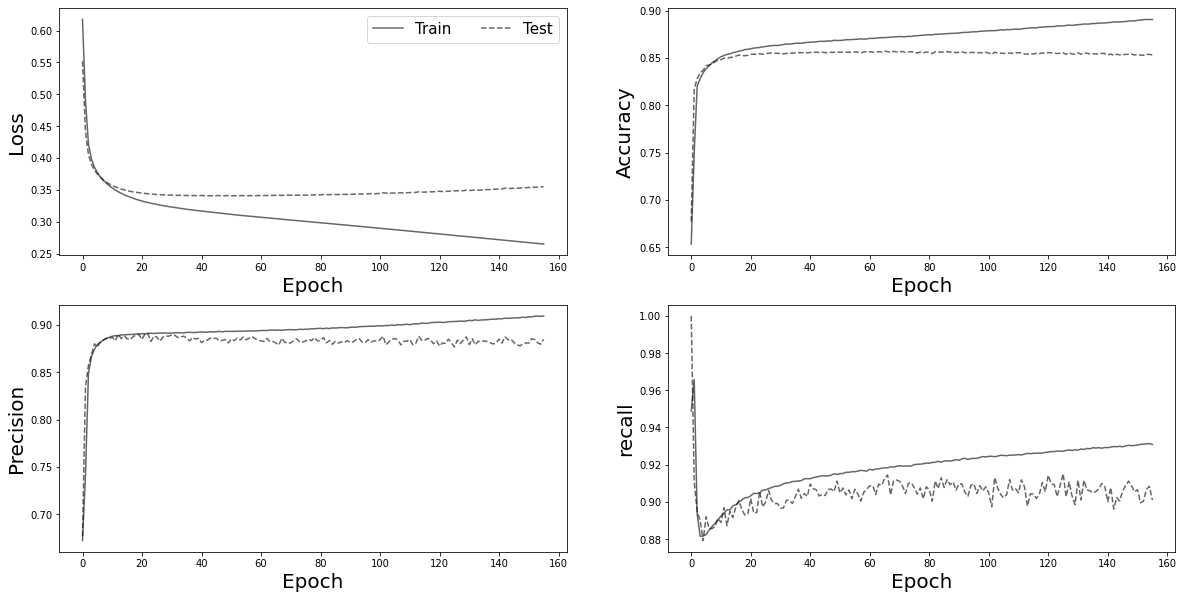

------------
Performances
------------
Loss: 0.340000 
Accuracy: 86 percent.
Precision: 88 percent.
Recall: 91 percent.


In [3]:
import matplotlib.pyplot as plt

epoch = np.arange(0, len(history.history['loss']))

fig = plt.figure(figsize=(20, 10))

plt.subplot(2,2,1)
plt.plot(epoch, history.history['loss'], color = 'k', label= 'Train', alpha = 0.6)
plt.plot(epoch, history.history['val_loss'], '--', color = 'k', label= 'Test', alpha = 0.6)
plt.xlabel('Epoch', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.legend(fontsize = 15, ncol = 2)

plt.subplot(2,2,2)
plt.plot(epoch, history.history['accuracy'], color = 'k', alpha = 0.6)
plt.plot(epoch, history.history['val_accuracy'], '--', color = 'k', alpha = 0.6)
plt.xlabel('Epoch', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)

plt.subplot(2,2,3)
plt.plot(epoch, history.history['precision'], color = 'k', alpha = 0.6)
plt.plot(epoch, history.history['val_precision'], '--', color = 'k', alpha = 0.6)
plt.xlabel('Epoch', fontsize = 20)
plt.ylabel('Precision', fontsize = 20)

plt.subplot(2,2,4)
plt.plot(epoch, history.history['recall'], color = 'k', alpha = 0.6)
plt.plot(epoch, history.history['val_recall'], '--', color = 'k', alpha = 0.6)
plt.xlabel('Epoch', fontsize = 20)
plt.ylabel('recall', fontsize = 20)

plt.show()

model_perf = model.evaluate(X_test, Y_test, verbose = False)
loss = np.round(model_perf[1], 2)
accuracy = int(np.round(model_perf[2], 2)*100.)
precision = int(np.round(model_perf[3], 2)*100.)
recall = int(np.round(model_perf[4], 2)*100.)
print('------------')
print('Performances')
print('------------')
print('Loss: %f '%(loss))
print('Accuracy: %i percent.'%(accuracy))
print('Precision: %i percent.'%(precision))
print('Recall: %i percent.'%(recall))

It seems that our model has trained, with the loss function smoothly decreasing with time. The model further seems to achieve pretty well &ndash; over 85% accuracy, high precision and recall &ndash; especially after accounting for the extreme simplicity of the model that we have chosen.

However, our model seems to learn pretty (too!) fast for few epochs, and then mainly stagnates for the rest of the training. We had a patience of 100 epochs for the callback, therefore the model is overfitting after only a few epochs.

In the notebook related to the data preparation, we noted an imbalance of the classes for this dataset (75/35 toward positive class). Therefore, the accuracy might not be the best metric to look at to assess the performances of this NLP algorithm. Instead we can use the Precision and Recall, and in particular we can look at the Fbeta-score which provides an harmonic mean of the two metrics.

For the Fbeta-score, we need to decide what $\beta$ to use. First, we consider $\beta~=~1$, corresponding to an equal weight between the precision and the recall of the trained model. However, we note that we are trying to build a classifier which provides a clean sample of comments (i.e. minimising false positives), since that the comments in the positive class will be used for further analysis. Therefore, for our classification problem, we need to put more weights toward precision than recall, and use instead $\beta~=~0.5$.

In [4]:
def fscore(beta, p, r):
    return ((1+beta*beta)*p*r)/(beta*beta*p + r)

F1_score = int(fscore(1, precision, recall))
F0p5_score = int(fscore(0.5, precision, recall))

print('The F1-score and F0.5-score are %i and %i percents, respectively.'%(F1_score, F0p5_score))

The F1-score and F0.5-score are 89 and 88 percents, respectively.


The F1-score and F0.5-score are identical and pretty high. However, we can still improve precision, probably at the expense of recall, but we can try to keep a high F0.5-score for future updates.

Finally, we can also look at the confusion matrix which provides an idea of how many comments have been mis-classified in each of the classes in terms of absolute numbers.

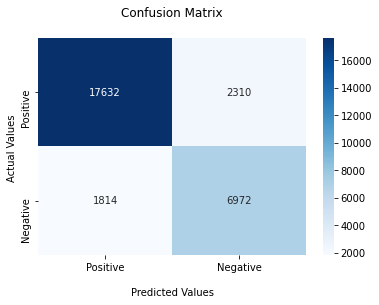

In [5]:
import seaborn as sns

y_predict = model(X_test, training=False).numpy()
thresh = 0.5
y_predict_label = [1 if y_predict_i[0] > thresh else 0 for y_predict_i in y_predict]

metric = tf.keras.metrics.TruePositives()
metric.update_state(Y_test, y_predict_label)
TP = int(metric.result().numpy())

metric = tf.keras.metrics.TrueNegatives()
metric.update_state(Y_test, y_predict_label)
TN = int(metric.result().numpy())

metric = tf.keras.metrics.FalsePositives()
metric.update_state(Y_test, y_predict_label)
FP = int(metric.result().numpy())

metric = tf.keras.metrics.FalseNegatives()
metric.update_state(Y_test, y_predict_label)
FN = int(metric.result().numpy())

# Confusion matrix
cf_matrix = np.array([[TP,FP],[FN,TN]])

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['Positive','Negative'])
ax.yaxis.set_ticklabels(['Positive','Negative'])
plt.show()

We note that the confusion matrix is mostly dark along the diagonal, suggesting that our classifier is doing a good job. In fact, we correctly classified over 17000 comments. However, we also note that we have over 2000 comments that have been mis-classified as useful, which could really be problematic if wanting to extract useful comments.

### Concluding remarks

Throughout this notebook I define, train, and test a model for the binary classification of comments. We have seen that we can already achieve some pretty high performances by using the simplest model possible. However, we have a rapid overfitting, and many comments that are mis-classified as useful. Future updates will have better, more complex models (e.g. adding regularisation, using a decaying learning rate), where the aim will be to minimise false positives in order to obtain a pure predicted sample of true positives.